In [115]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import itertools
import re
import time

from collections import Counter
#sns.set()
sns.set(style="white", color_codes=True)
%matplotlib inline

# LNA

In [39]:
# import data for seasonal rankings
rankings_path = 'Data/Team/Rankings/regular/lna/*'
df_rankings_lna = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[31:35]
    df_rankings_lna.append(frame)
df_rankings_lna = pd.concat(df_rankings_lna)
df_rankings_lna.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_rankings_lna.head(15)

,R,Team,GP,W,OTW,SOW,SOL,OTL,L,GF,GA,GDF,PTS,Season
0,1,SC Bern,50,30,4,0,2,3,11,187,136,51,103,0809
1,2,ZSC Lions,50,26,3,5,0,3,13,176,149,27,97,0809
2,3,Kloten Flyers,50,27,3,3,2,1,14,174,130,44,96,0809
3,4,HC Davos,50,25,3,3,3,2,14,184,135,49,92,0809
4,5,HC Lugano,50,19,4,4,5,2,16,175,156,19,80,0809
5,6,Genève-Servette HC,50,22,5,0,2,0,21,157,140,17,78,0809
6,7,Fribourg-Gottéron,50,19,3,4,1,3,20,154,143,11,75,0809
7,8,EV Zug,50,20,1,2,2,3,22,171,166,5,71,0809
8,9,SCL Tigers,50,19,2,3,1,1,24,170,180,-10,69,0809
9,10,SC Rapperswil-Jona Lakers,50,14,0,1,2,3,30,143,208,-65,49,0809


In [40]:
# helper to sort plots by median rank/pts
temp_lna = df_rankings_lna.groupby('Team').agg({'R': 'median', 'PTS': 'median'})
t1_lna = temp_lna.sort_values(by='R',inplace=False)
t2_lna = temp_lna.sort_values(by='PTS',ascending=False)

In [41]:
df_rankings_lna_grouped = df_rankings_lna.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first', 'PTS': 'first'})
df_features_lna = df_rankings_lna.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first'})
df_rankings_lna.drop(['GP','W','OTW','SOW','SOL','OTL','L','GF','GA','GDF','PTS','Season'],axis=1,inplace=True)

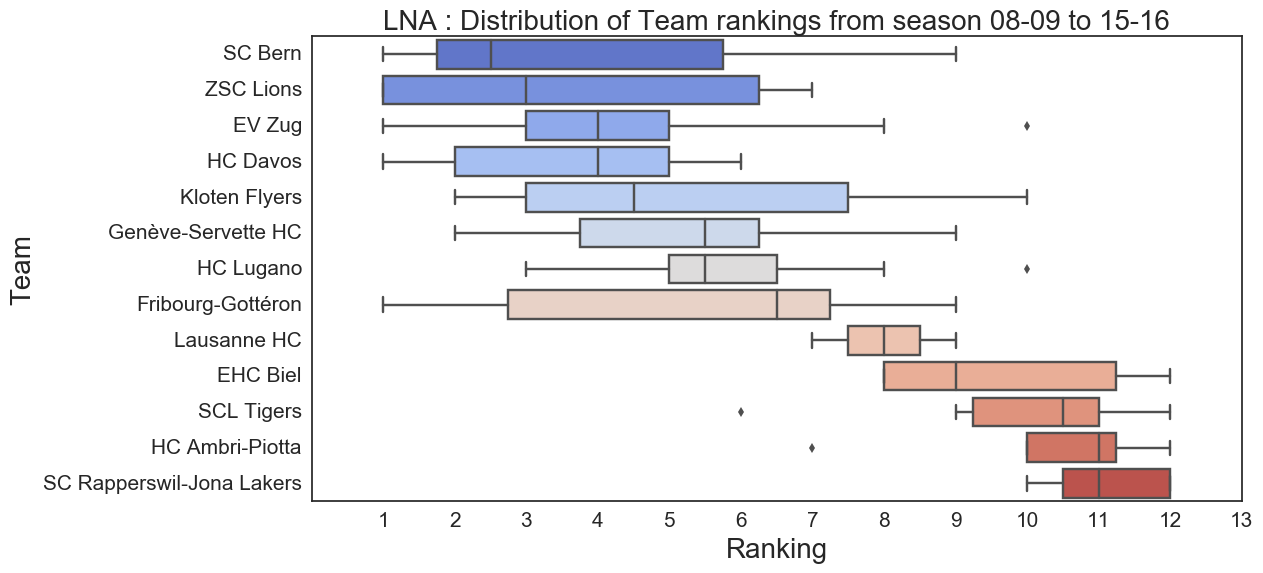

In [129]:
# plot
plt.figure(figsize=(12,6))
ax = sns.boxplot(x='R', y='Team',data=df_rankings_lna_grouped.reset_index(), orient="h", palette='coolwarm', order=t1_lna.index)
ax.set_xlabel('Ranking', fontsize=20)
ax.set_xticks(np.arange(1,14))
ax.set_title('LNA : Distribution of Team rankings from season 08-09 to 15-16', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Team',fontsize=20)
plt.savefig('Plots/lna_rank_distrib.png')


# # plot
# plt.figure(figsize=(12,6))
# ax = sns.boxplot(x='R', y='Team',data=df_rankings_lnb_grouped.reset_index(), orient="h", palette='coolwarm', order=t1_lnb.index)
# ax.set_xlabel('Ranking', fontsize=20)
# ax.set_xticks(np.arange(1,14))
# ax.set_title('LNB : Distribution of Team rankings from season 09-10 to 15-16', fontsize=20);
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylabel('Team',fontsize=20)
# plt.savefig('Plots/lnb_rank_distrib.png')

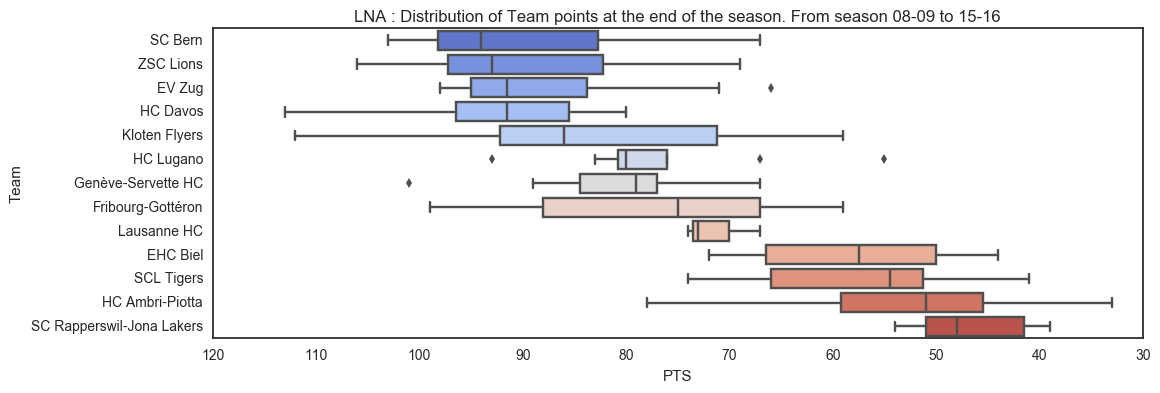

In [43]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings_lna_grouped.reset_index(), orient="h", palette='coolwarm', order=t2_lna.index)
ax.set_xlabel('PTS')
ax.invert_xaxis()
#ax.set_xticks(np.arange(1,14))
ax.set_title('LNA : Distribution of Team points at the end of the season. From season 08-09 to 15-16');

plt.savefig('Plots/lna_points_distrib.png')

In [44]:
playoff_ranks_lna = [5,5,2,1,5,5,3,3,
                1,2,3,5,3,5,5,5,
                1,2,3,3,5,5,5,5,
                3,5,3,5,2,5,1,5,
                2,1,3,3,5,5,5,5,
                1,3,2,3,5,5,5,5,
                2,3,5,5,1,3,5,5,
                5,3,3,5,2,5,5,1]
df_rankings_lna = df_rankings_lna[df_rankings_lna['R'] <= 8]

In [45]:
df_rankings_lna['playoff'] = playoff_ranks_lna
df_rankings_lna.rename(index=str, columns={'playoff' : 'rank_PO', 'R' : 'rank_RE'},inplace=True)
df_rankings_lna['number'] = 20
df_rankings_lna_agg = df_rankings_lna.groupby(by=['rank_RE', 'rank_PO']).agg({'number' : 'sum'}).reset_index()

In [46]:
df_rankings_lna_agg['total'] = df_rankings_lna_agg.apply(lambda x: x.loc['rank_RE']*x.loc['number'], axis=1)
df_rankings_lna_mean = df_rankings_lna_agg.groupby(['rank_PO']).agg({'total' : 'sum', 'number' : 'sum'})
df_rankings_lna_mean['mean'] = df_rankings_lna_mean['total']/df_rankings_lna_mean['number']
df_rankings_lna_mean

,total,number,mean
rank_PO,,,
1,580,160,3.62500
2,440,160,2.75000
3,1200,320,3.75000
5,3540,640,5.53125


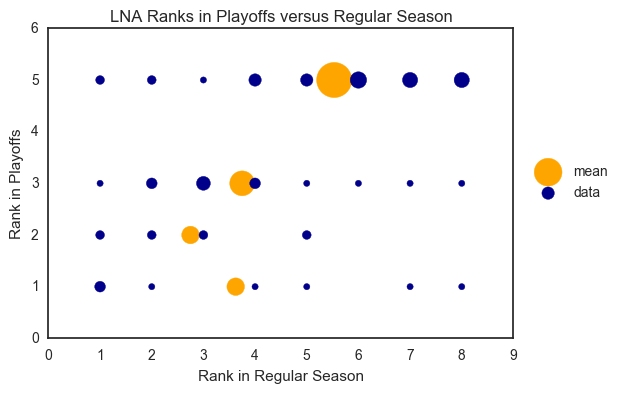

In [47]:
plt.scatter(x=df_rankings_lna_mean['mean'],y=df_rankings_lna_mean.reset_index()['rank_PO'],
            s=df_rankings_lna_mean['number'], color='orange', label='mean')
plt.scatter(x=df_rankings_lna_agg['rank_RE'],y=df_rankings_lna_agg['rank_PO'],
            s=df_rankings_lna_agg['number'], color='darkblue', label='data')
plt.xlabel('Rank in Regular Season')
plt.ylabel('Rank in Playoffs')
plt.ylim([0,6])
plt.legend(bbox_to_anchor=(1.23, 0.6))
plt.title('LNA Ranks in Playoffs versus Regular Season')
plt.savefig('Plots/lna_PO_vs_RE.png')

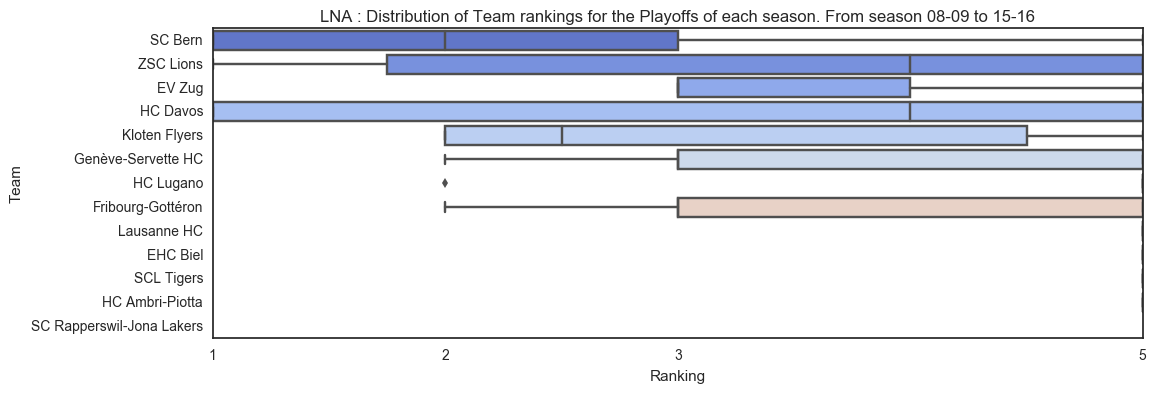

In [48]:
# plot
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='rank_PO', y='Team',data=df_rankings_lna, orient="h", palette='coolwarm', order=t1_lna.index)
ax.set_xlabel('Ranking')
ax.set_xticks([1,2,3,5])
ax.set_title('LNA : Distribution of Team rankings for the Playoffs of each season. From season 08-09 to 15-16');

plt.savefig('Plots/lna_playoff_distrib.png')

# LNB

In [49]:
# import data for seasonal rankings
rankings_path = 'Data/Team/Rankings/regular/lnb/*'
df_rankings_lnb = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[31:35]
    df_rankings_lnb.append(frame)
df_rankings_lnb = pd.concat(df_rankings_lnb)
df_rankings_lnb.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_rankings_lnb.head(15)

,R,Team,GP,W,OTW,SOW,SOL,OTL,L,GF,GA,GDF,PTS,Season
0,1,EHC Visp,45,27,3,3,1,1,10,224,140,84,95,0910
1,2,EHC Olten,45,30,0,1,2,0,12,187,129,58,94,0910
2,3,Lausanne HC,45,28,1,1,2,1,12,166,121,45,91,0910
3,4,HC Sierre,45,21,2,3,4,3,12,161,132,29,80,0910
4,5,HC Ajoie,45,21,3,2,1,1,17,157,149,8,75,0910
5,6,HC La Chaux-de-Fonds,45,20,2,0,4,0,19,177,166,11,68,0910
6,7,SC Langenthal,45,16,0,3,0,0,26,124,156,-32,54,0910
7,8,EHC Basel Sharks,45,12,0,1,2,2,28,111,180,-69,42,0910
8,9,Hockey Thurgau,45,12,0,1,1,3,28,131,189,-58,42,0910
9,10,GCK Lions,45,10,0,2,0,0,33,123,199,-76,34,0910


In [50]:
# helper to sort plots by median rank/pts
temp_lnb = df_rankings_lnb.groupby('Team').agg({'R': 'median', 'PTS': 'median'})
t1_lnb = temp_lnb.sort_values(by='R',inplace=False)
t2_lnb = temp_lnb.sort_values(by='PTS',ascending=False)

In [51]:
df_rankings_lnb_grouped = df_rankings_lnb.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first', 'PTS': 'first'})
df_features_lnb = df_rankings_lnb.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first'})
df_rankings_lnb.drop(['GP','W','OTW','SOW','SOL','OTL','L','GF','GA','GDF','PTS','Season'],axis=1,inplace=True)

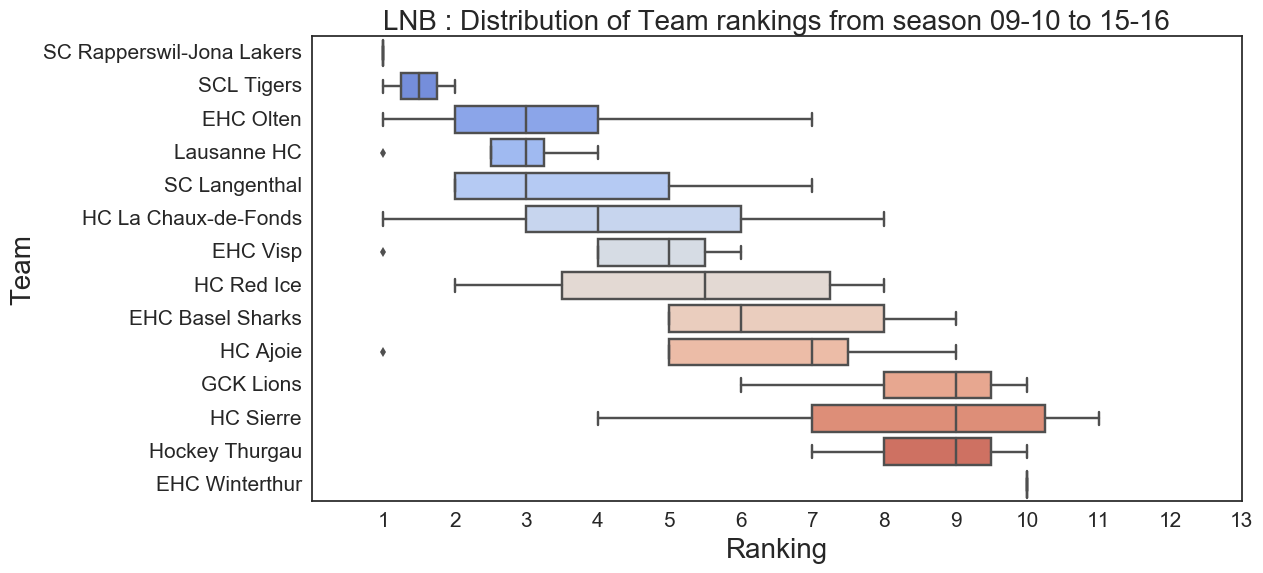

In [127]:
# plot
plt.figure(figsize=(12,6))
ax = sns.boxplot(x='R', y='Team',data=df_rankings_lnb_grouped.reset_index(), orient="h", palette='coolwarm', order=t1_lnb.index)
ax.set_xlabel('Ranking', fontsize=20)
ax.set_xticks(np.arange(1,14))
ax.set_title('LNB : Distribution of Team rankings from season 09-10 to 15-16', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Team',fontsize=20)
plt.savefig('Plots/lnb_rank_distrib.png')

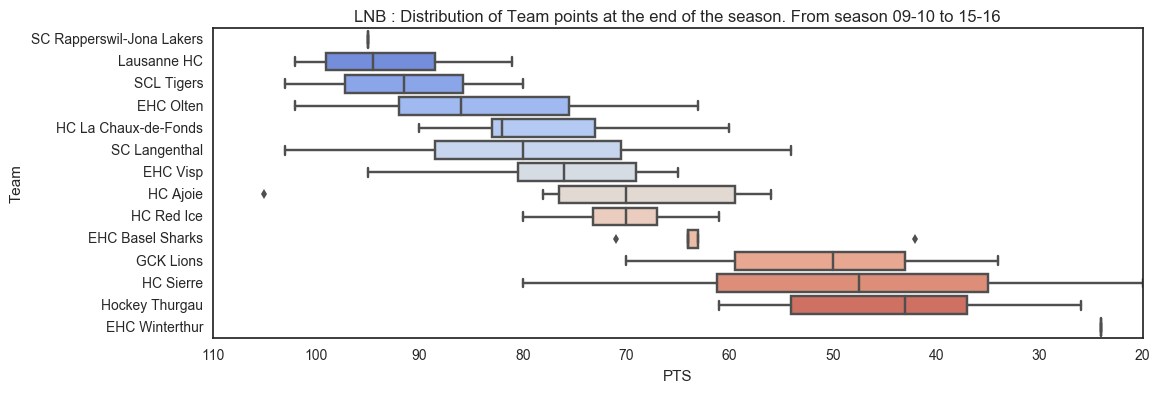

In [53]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings_lnb_grouped.reset_index(), orient="h", palette='coolwarm', order=t2_lnb.index)
ax.set_xlabel('PTS')
ax.invert_xaxis()
#ax.set_xticks(np.arange(1,14))
ax.set_title('LNB : Distribution of Team points at the end of the season. From season 09-10 to 15-16');

plt.savefig('Plots/lnb_points_distrib.png')

In [54]:
playoff_ranks_lnb = [2,3,1,3,5,5,5,5,
                    3,3,2,5,5,1,5,5,
                    2,1,3,3,5,5,5,5,
                    3,3,2,1,5,5,5,5,
                    5,2,3,5,1,5,5,3,
                    1,3,5,5,2,3,5,5,
                    2,5,3,5,5,5,3,5]
df_rankings_lnb = df_rankings_lnb[df_rankings_lnb['R'] <= 8]

In [55]:
df_rankings_lnb['playoff'] = playoff_ranks_lnb
df_rankings_lnb.rename(index=str, columns={'playoff' : 'rank_PO', 'R' : 'rank_RE'},inplace=True)
df_rankings_lnb['number'] = 20
df_rankings_lnb_agg = df_rankings_lnb.groupby(by=['rank_RE', 'rank_PO']).agg({'number' : 'sum'}).reset_index()

In [56]:
df_rankings_lnb_agg['total'] = df_rankings_lnb_agg.apply(lambda x: x.loc['rank_RE']*x.loc['number'], axis=1)
df_rankings_lnb_mean = df_rankings_lnb_agg.groupby(['rank_PO']).agg({'total' : 'sum', 'number' : 'sum'})
df_rankings_lnb_mean['mean'] = df_rankings_lnb_mean['total']/df_rankings_lnb_mean['number']
df_rankings_lnb_mean

,total,number,mean
rank_PO,,,
1,420,120,3.500000
2,320,140,2.285714
3,960,280,3.428571
5,3340,580,5.758621


/Users/fredericmoret/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


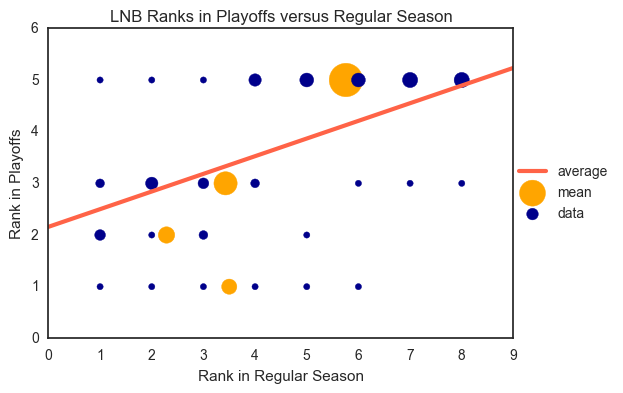

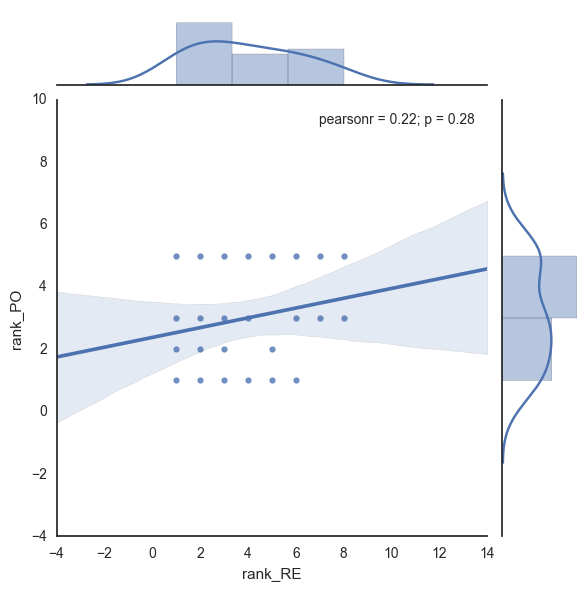

In [84]:
aa = df_rankings_lnb.rank_RE.values
bb = df_rankings_lnb.rank_PO.values
fit = np.polyfit(aa, bb, 1)
fit_fn = np.poly1d(fit)
a = range(0,10)
plt.plot(a,fit_fn(a), linewidth=3, color='tomato', label='average')
plt.scatter(x=df_rankings_lnb_mean['mean'],y=df_rankings_lnb_mean.reset_index()['rank_PO'],
            s=df_rankings_lnb_mean['number'], color='orange', label='mean')
plt.scatter(x=df_rankings_lnb_agg['rank_RE'],y=df_rankings_lnb_agg['rank_PO'],
            s=df_rankings_lnb_agg['number'], color='darkblue', label='data')
plt.xlabel('Rank in Regular Season')
plt.ylabel('Rank in Playoffs')
plt.ylim([0,6])
plt.xlim([0,9])
plt.legend(bbox_to_anchor=(1.23, 0.6))
plt.title('LNB Ranks in Playoffs versus Regular Season')
plt.savefig('Plots/lnb_PO_vs_RE.png')

sns.jointplot(x='rank_RE', y='rank_PO', data=df_rankings_lnb_agg, kind='reg')

In [58]:
len(playoff_ranks_lnb)

56

# Features

In [59]:
df_stats = pd.read_csv('Data/Cleaned_Data/team_regular_season.csv')
df_stats.rename(index=str, columns={'Year' : 'Season'}, inplace=True)
df_stats.set_index(['Team','Season'], inplace=True)
df_stats.drop(['Number of year'],axis=1,inplace=True)
df_stats.head(10)

GF  PK SI  PK SI/GP  PK GA  PK GA/GP    PK%    PKT  \
Team             Season                                                        
EHC Basel Sharks 910     111    224      4.98     53      1.18  76.34  19961   
                 1011    138    211      4.69     38      0.84  81.99  19849   
                 1112    132    212      4.71     45      1.00  78.77  18770   
                 1213    138    232      4.64     46      0.92  80.17  21341   
                 1314    144    209      4.64     41      0.91  80.38  19490   
EHC Biel         809     126    306      6.12     55      1.10  82.03  27694   
                 910     134    266      5.32     45      0.90  83.08  24336   
                 1011    135    201      4.02     47      0.94  76.62  19409   
                 1112    114    200      4.00     35      0.70  82.50  19787   
                 1213    160    198      3.96     33      0.66  83.33  19053   

                         PK time/GP  SHG  PK GF/GP     ...      5'  10'  GM  \
Team             Season                                ...                    
EHC Basel Sharks 910            443    2      0.04     ...       0   12   0   
                 1011           441    6      0.13     ...       3    2   2   
                 1112           417    9      0.20     ...       1    4   0   
                 1213           426    8      0.16     ...       2   10   1   
                 1314           433    8      0.18     ...       3   12   2   
EHC Biel         809            553    3      0.06     ...       2    8   4   
                 910            486    7      0.14     ...       2   12   1   
                 1011           388    3      0.06     ...       4    8   4   
                 1112           395    1      0.02     ...       6    2   5   
                 1213           381    7      0.14     ...       1    8   1   

                         MP  PIM Total  PP OP  PP OP/GP    PP%    PPT  \
Team             Season                                                 
EHC Basel Sharks 910      0        642    198      4.40  16.67  18182   
                 1011     2        597    197      4.38  16.75  18728   
                 1112     1        517    183      4.07  14.75  16934   
                 1213     1        662    189      3.78  18.52  18475   
                 1314     1        667    185      4.11  21.62  17106   
EHC Biel         809      0        812    261      5.22  11.11  25912   
                 910      1        776    259      5.18  16.99  23920   
                 1011     0        632    201      4.02  19.40  19384   
                 1112     1        602    198      3.96  15.15  19433   
                 1213     0        583    231      4.62  16.02  21809   

                         PP time/GP  
Team             Season              
EHC Basel Sharks 910            404  
                 1011           416  
                 1112           376  
                 1213           369  
                 1314           380  
EHC Biel         809            518  
                 910            478  
                 1011           387  
                 1112           388  
                 1213           436  

[10 rows x 34 columns]

## lna

In [60]:
df_features_lna.reset_index(inplace=True)
df_features_lna[['Season']] = df_features_lna[['Season']].apply(pd.to_numeric)
df_features_lna = df_features_lna.drop(df_features_lna[df_features_lna.Season == 809].index)
df_features_lna.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_features_lna.set_index(['Team','Season'],inplace=True)
df_features_lna.head(5)

R
Team     Season    
EHC Biel 910      9
         1011     9
         1112     8
         1213     8
         1314    11

In [61]:
df_feat_viz_lna = df_features_lna.join(df_stats, how='inner')
print('number of entries : ', len(df_feat_viz_lna))
df_feat_viz_lna['League'] = 'LNA'
df_feat_viz_lna.head(10)

number of entries :  84


R   GF  PK SI  PK SI/GP  PK GA  PK GA/GP    PK%    PKT  \
Team     Season                                                            
EHC Biel 910      9  134    266      5.32     45      0.90  83.08  24336   
         1011     9  135    201      4.02     47      0.94  76.62  19409   
         1112     8  114    200      4.00     35      0.70  82.50  19787   
         1213     8  160    198      3.96     33      0.66  83.33  19053   
         1314    11  115    197      3.94     34      0.68  82.74  17888   
         1415     8  142    167      3.34     37      0.74  77.84  15684   
         1516    12  128    197      3.94     53      1.06  73.10  16987   
EV Zug   910      3  165    229      4.58     34      0.68  85.15  22240   
         1011     4  176    224      4.48     37      0.74  83.48  22101   
         1112     1  173    221      4.42     27      0.54  87.78  22282   

                 PK time/GP  SHG   ...    10'  GM  MP  PIM Total  PP OP  \
Team     Season                    ...                                    
EHC Biel 910            486    7   ...     12   1   1        776    259   
         1011           388    3   ...      8   4   0        632    201   
         1112           395    1   ...      2   5   1        602    198   
         1213           381    7   ...      8   1   0        583    231   
         1314           357    5   ...      2   1   0        468    197   
         1415           313    3   ...      5   3   0        498    188   
         1516           339    3   ...      3   4   0        536    200   
EV Zug   910            444    6   ...     12   3   0        773    221   
         1011           442    2   ...     21   7   0        930    200   
         1112           445    5   ...     11   7   1        870    198   

                 PP OP/GP    PP%    PPT  PP time/GP  League  
Team     Season                                              
EHC Biel 910         5.18  16.99  23920         478     LNA  
         1011        4.02  19.40  19384         387     LNA  
         1112        3.96  15.15  19433         388     LNA  
         1213        4.62  16.02  21809         436     LNA  
         1314        3.94  15.23  18264         365     LNA  
         1415        3.76  18.62  18357         367     LNA  
         1516        4.00  22.00  18668         373     LNA  
EV Zug   910         4.42  22.62  20536         410     LNA  
         1011        4.00  18.00  19159         383     LNA  
         1112        3.96  20.71  22629         452     LNA  

[10 rows x 36 columns]

## lnb

In [62]:
df_features_lnb.reset_index(inplace=True)
df_features_lnb[['Season']] = df_features_lnb[['Season']].apply(pd.to_numeric)
df_features_lnb = df_features_lnb.drop(df_features_lnb[df_features_lnb.Season == 809].index)
df_features_lnb.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_features_lnb.set_index(['Team','Season'],inplace=True)
df_features_lnb.head(5)

R
Team             Season   
EHC Basel Sharks 910     8
                 1011    5
                 1112    5
                 1213    9
                 1314    6

In [63]:
df_feat_viz_lnb = df_features_lnb.join(df_stats, how='inner')
print('number of entries : ', len(df_feat_viz_lnb))
df_feat_viz_lnb['League'] = 'LNB'
df_feat_viz_lnb.head(10)

number of entries :  70


R   GF  PK SI  PK SI/GP  PK GA  PK GA/GP    PK%  \
Team             Season                                                    
EHC Basel Sharks 910     8  111    224      4.98     53      1.18  76.34   
                 1011    5  138    211      4.69     38      0.84  81.99   
                 1112    5  132    212      4.71     45      1.00  78.77   
                 1213    9  138    232      4.64     46      0.92  80.17   
                 1314    6  144    209      4.64     41      0.91  80.38   
EHC Olten        910     2  187    193      4.29     39      0.87  79.79   
                 1011    2  192    211      4.69     28      0.62  86.73   
                 1112    7  152    185      4.11     27      0.60  85.41   
                 1213    3  217    204      4.08     40      0.80  80.39   
                 1314    1  166    212      4.71     32      0.71  84.91   

                           PKT  PK time/GP  SHG   ...    10'  GM  MP  \
Team             Season                           ...                  
EHC Basel Sharks 910     19961         443    2   ...     12   0   0   
                 1011    19849         441    6   ...      2   2   2   
                 1112    18770         417    9   ...      4   0   1   
                 1213    21341         426    8   ...     10   1   1   
                 1314    19490         433    8   ...     12   2   1   
EHC Olten        910     17701         393    5   ...      5   0   0   
                 1011    20858         463   11   ...      9   0   0   
                 1112    18120         402    5   ...      9   1   0   
                 1213    19263         385    1   ...      8   2   0   
                 1314    19887         441   10   ...      9   4   1   

                         PIM Total  PP OP  PP OP/GP    PP%    PPT  PP time/GP  \
Team             Season                                                         
EHC Basel Sharks 910           642    198      4.40  16.67  18182         404   
                 1011          597    197      4.38  16.75  18728         416   
                 1112          517    183      4.07  14.75  16934         376   
                 1213          662    189      3.78  18.52  18475         369   
                 1314          667    185      4.11  21.62  17106         380   
EHC Olten        910           518    247      5.49  20.24  23692         526   
                 1011          574    236      5.24  24.58  20843         463   
                 1112          543    234      5.20  18.80  23208         515   
                 1213          633    264      5.28  21.59  23619         472   
                 1314          716    221      4.91  18.10  18842         418   

                         League  
Team             Season          
EHC Basel Sharks 910        LNB  
                 1011       LNB  
                 1112       LNB  
                 1213       LNB  
                 1314       LNB  
EHC Olten        910        LNB  
                 1011       LNB  
                 1112       LNB  
                 1213       LNB  
                 1314       LNB  

[10 rows x 36 columns]

In [64]:
df_feat_leagues = pd.concat([df_feat_viz_lna,df_feat_viz_lnb])
df_feat_leagues.head(5)

R   GF  PK SI  PK SI/GP  PK GA  PK GA/GP    PK%    PKT  \
Team     Season                                                            
EHC Biel 910      9  134    266      5.32     45      0.90  83.08  24336   
         1011     9  135    201      4.02     47      0.94  76.62  19409   
         1112     8  114    200      4.00     35      0.70  82.50  19787   
         1213     8  160    198      3.96     33      0.66  83.33  19053   
         1314    11  115    197      3.94     34      0.68  82.74  17888   

                 PK time/GP  SHG   ...    10'  GM  MP  PIM Total  PP OP  \
Team     Season                    ...                                    
EHC Biel 910            486    7   ...     12   1   1        776    259   
         1011           388    3   ...      8   4   0        632    201   
         1112           395    1   ...      2   5   1        602    198   
         1213           381    7   ...      8   1   0        583    231   
         1314           357    5   ...      2   1   0        468    197   

                 PP OP/GP    PP%    PPT  PP time/GP  League  
Team     Season                                              
EHC Biel 910         5.18  16.99  23920         478     LNA  
         1011        4.02  19.40  19384         387     LNA  
         1112        3.96  15.15  19433         388     LNA  
         1213        4.62  16.02  21809         436     LNA  
         1314        3.94  15.23  18264         365     LNA  

[5 rows x 36 columns]

In [113]:
sns.set(color_codes=True,font_scale=2.5)
init_time = time.time()
i = 1
for current in [y for y in df_feat_leagues.columns if y not in ['League','R']]:
    fig = plt.figure(figsize=(15,15))
    pal = dict(LNA="seagreen", LNB="gold")
    g = sns.lmplot(x='R', y=current, hue='League', data=df_feat_leagues, palette=pal, legend_out=True, size=12,
                   scatter_kws={"s": 300,'edgecolors': 'black', 'lw': 1.5 },
                   line_kws={'lw':8, 'path_effects':[pe.Stroke(linewidth=10, foreground='black'), pe.Normal()]})
    plt.xlabel('Rank', fontsize=40)
    plt.ylabel(current, fontsize=40)
#    plt.xticks(fontsize=20)
#    plt.yticks(fontsize=20)
    plt.title('Rank versus {}'.format(current), fontsize=40)
#     plt.legend(fontsize=40)
    plt.savefig('Plots/features/Ranking__vs__{}'.format(re.sub('[\s/]', '_', current)))
plt.close('all')

/Users/fredericmoret/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [66]:
#     ax = sns.jointplot(x=df_feat_viz['R'], y=df_feat_viz[x], kind='reg')
# #    ax.set_xlabel(x)
# #    ax.set_ylabel(y)
#     plt.savefig(r'Plots/features/{}_vs_{}'.format(re.sub('[\s/]', '_', x),re.sub('[\s/]', '_', y)))
#     plt.close(ax.fig)
#     a = range(-5,21)
#     colors = ['seagreen','gray']
#     i = 0
#     g = sns.JointGrid("R", x, df_feat_leagues)
#     for league, dframe in df_feat_leagues.groupby('League'):
#         fit = np.polyfit(dframe.R.values, dframe[x].values, 1)
#         fit_fn = np.poly1d(fit)
#         g.ax_joint.plot(a,fit_fn(a),linewidth=3, color=colors[i], label='red')
#         sns.kdeplot(dframe['R'], ax=g.ax_marg_x, legend=False, color=colors[i])
#         sns.kdeplot(dframe[x], ax=g.ax_marg_y, vertical=True, legend=False, color=colors[i])
#         g.ax_joint.plot(dframe['R'], dframe[x], marker='o', ms=5, color=colors[i],linewidth=0)
#         i += 1
        
#     fig2 = plt.figure(figsize=(8,8))
#     sns.jointplot(x='R',y='GF',data=df_feat_leagues, kind='reg')
    
#     g = sns.pairplot(df_feat_leagues[["R", "GF", "League"]], hue="League", diag_kind="hist")
#     g.map_upper(sns.regplot)
#     for ax in g.axes.flat:
#         plt.setp(ax.get_xticklabels(), rotation=45)